In [ ]:
# Step 5: Merge datasets
# -------------------------------
for df in [enrol_agg, bio_agg, demo_agg]:
    df["state"] = df["state"].astype(str).str.strip().str.lower()


final_df = enrol_agg.merge(bio_agg, on=["state", "year_month"], how="left")
print(final_df['state'].unique())
final_df = final_df.merge(demo_agg, on=["state", "year_month"], how="left")
final_df.fillna(0, inplace=True)
print(final_df['state'].unique())



# -------------------------------
# Step 6: Feature Engineering
# -------------------------------

# 1️⃣ Total update load
final_df["total_update_load"] = (
    final_df["total_biometric_updates"] +
    final_df["total_demographic_updates"]
)

# 2️⃣ Update-to-enrollment ratio
final_df["update_to_enrollment_ratio"] = (
    final_df["total_update_load"] / final_df["total_enrolment"]
)

# 3️⃣ Enrollment growth rate (month-over-month)
final_df = final_df.sort_values(["state", "year_month"])
final_df["enrollment_growth_rate"] = (
    final_df.groupby("state")["total_enrolment"].pct_change()
)

# 4️⃣ Biometric update share
final_df["biometric_update_share"] = (
    final_df["total_biometric_updates"] / final_df["total_update_load"]
)
print(final_df['state'].unique())
# Handle infinities and NaNs
final_df.replace([np.inf, -np.inf], 0, inplace=True)
final_df.fillna(0, inplace=True)
print(final_df['state'].unique())
# Save final dataset
final_df.to_csv("/content/feature_engineered_uidai_data.csv", index=False)

print(final_df)

['andaman & nicobar islands' 'andhra pradesh' 'arunachal pradesh' 'assam'
 'bihar' 'chandigarh' 'chhattisgarh' 'dadra & nagar haveli'
 'dadra & nagar haveli and daman & diu' 'daman & diu' 'delhi' 'goa'
 'gujarat' 'haryana' 'himachal pradesh' 'jammu & kashmir' 'jharkhand'
 'karnataka' 'kerala' 'ladakh' 'lakshadweep' 'madhya pradesh'
 'maharashtra' 'manipur' 'meghalaya' 'mizoram' 'nagaland' 'odisha'
 'orissa' 'pondicherry' 'puducherry' 'punjab' 'rajasthan' 'sikkim'
 'tamil nadu' 'telangana' 'the dadra and nagar haveli and daman and diu'
 'tripura' 'uttar pradesh' 'uttarakhand' 'west  bengal' 'west bangal'
 'west bengal' 'westbengal']
['andaman & nicobar islands' 'andhra pradesh' 'arunachal pradesh' 'assam'
 'bihar' 'chandigarh' 'chhattisgarh' 'dadra & nagar haveli'
 'dadra & nagar haveli and daman & diu' 'daman & diu' 'delhi' 'goa'
 'gujarat' 'haryana' 'himachal pradesh' 'jammu & kashmir' 'jharkhand'
 'karnataka' 'kerala' 'ladakh' 'lakshadweep' 'madhya pradesh'
 'maharashtra' 'manipur' '

In [ ]:
# -------------------------------
# PART 4 — ANOMALY DETECTION
# -------------------------------

# Compute state-wise mean and standard deviation of the 'update_to_enrollment_ratio'
stats = (
    final_df
    .groupby("state", as_index=False)["update_to_enrollment_ratio"]
    .agg(mean_update_ratio="mean", std_update_ratio="std")
)

# Merge these statistics back into the main dataframe
final_df = final_df.merge(stats, on="state", how="left")

# Avoid division by zero when calculating Z-score: replace 0 std dev with NaN
final_df["std_update_ratio"] = final_df["std_update_ratio"].replace(0, np.nan)

# Compute Z-score for 'update_to_enrollment_ratio'
# Z-score = (value - mean) / standard deviation
final_df["z_score"] = (
    (final_df["update_to_enrollment_ratio"] - final_df["mean_update_ratio"]) /
    final_df["std_update_ratio"]
)

# Flag anomalies: A data point is an anomaly if the absolute Z-score is greater than 2
final_df["anomaly_flag"] = final_df["z_score"].abs() > 2
# Fill any NaN in anomaly_flag (e.g., from states with constant update ratios) with False and convert to integer
final_df["anomaly_flag"] = final_df["anomaly_flag"].fillna(False).astype(int)

# Save the updated dataset including anomaly flags
final_df.to_csv("/content/feature_engineered_with_anomalies.csv", index=False)

print(final_df[["state", "year_month", "update_to_enrollment_ratio", "z_score", "anomaly_flag"]])


                         state year_month  update_to_enrollment_ratio  \
0    andaman & nicobar islands 2025-01-01                    1.900000   
1    andaman & nicobar islands 2025-02-01                    9.083333   
2    andaman & nicobar islands 2025-03-01                  188.200000   
3    andaman & nicobar islands 2025-04-01                  168.411765   
4    andaman & nicobar islands 2025-05-01                  217.333333   
..                         ...        ...                         ...   
488                west bengal 2025-11-01                   32.676050   
489                west bengal 2025-12-01                   33.770586   
490                 westbengal 2025-02-01                    0.000000   
491                 westbengal 2025-05-01                    0.000000   
492                 westbengal 2025-12-01                   11.000000   

      z_score  anomaly_flag  
0   -0.874230             0  
1   -0.844450             0  
2   -0.101887             0  
3  

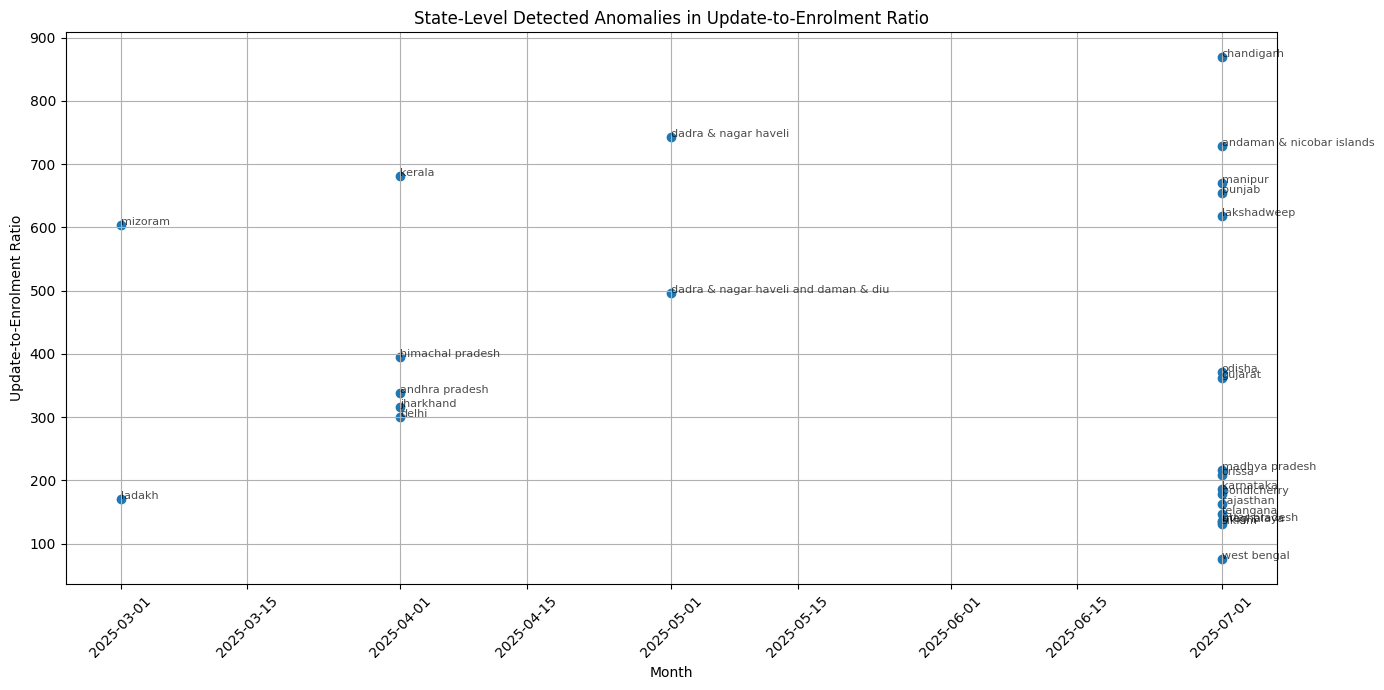

In [ ]:
import matplotlib.pyplot as plt

# Filter only anomalies
anomalies = final_df[final_df["anomaly_flag"] == 1]

plt.figure(figsize=(14, 7))
plt.scatter(anomalies["year_month"], anomalies["update_to_enrollment_ratio"])

# Add state labels to each anomaly point
for _, row in anomalies.iterrows():
    plt.text(row["year_month"], row["update_to_enrollment_ratio"], row["state"],
             fontsize=8, alpha=0.7)

plt.title("State-Level Detected Anomalies in Update-to-Enrolment Ratio")
plt.xlabel("Month")
plt.ylabel("Update-to-Enrolment Ratio")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# -------------------------------
# PART 5 — RULE-BASED RISK SCORING
# -------------------------------

# Ensure anomaly_flag exists and handle potential NaNs (though it should be handled in previous steps)
final_df["anomaly_flag"] = final_df["anomaly_flag"].fillna(0)

# Rule 1: Low enrolment growth - Flag if enrollment growth rate is less than -10%
final_df["low_enrolment_flag"] = final_df["enrollment_growth_rate"] < -0.10

# Rule 2: High update ratio - Flag if update-to-enrollment ratio is greater than 1.5
final_df["high_update_ratio_flag"] = final_df["update_to_enrollment_ratio"] > 1.5

# Rule 3: Anomaly detected - Flag if the anomaly_flag from Z-score analysis is 1
final_df["anomaly_detected_flag"] = final_df["anomaly_flag"] == 1

# Assign risk score based on the defined rules and their weights
# Low enrolment growth (weight 2) + High update ratio (weight 2) + Anomaly detected (weight 1)
final_df["risk_score"] = (
    final_df["low_enrolment_flag"].astype(int) * 2 +
    final_df["high_update_ratio_flag"].astype(int) * 2 +
    final_df["anomaly_detected_flag"].astype(int) * 1
)

# Define a function to categorize the calculated risk score into 'Normal', 'Moderate Risk', or 'High Risk'
def categorize_risk(score):
    if score <= 1:
        return "Normal"
    elif score <= 3:
        return "Moderate Risk"
    else:
        return "High Risk"

# Apply the risk categorization function to create a new 'risk_category' column
final_df["risk_category"] = final_df["risk_score"].apply(categorize_risk)

print(final_df.head())


                       state year_month  total_enrolment  \
0  andaman & nicobar islands 2025-01-01               30   
1  andaman & nicobar islands 2025-02-01               12   
2  andaman & nicobar islands 2025-03-01               15   
3  andaman & nicobar islands 2025-04-01               17   
4  andaman & nicobar islands 2025-05-01                9   

   total_biometric_updates  total_demographic_updates  total_update_load  \
0                      0.0                       57.0               57.0   
1                      0.0                      109.0              109.0   
2                   2703.0                      120.0             2823.0   
3                   2744.0                      119.0             2863.0   
4                   1895.0                       61.0             1956.0   

   update_to_enrollment_ratio  enrollment_growth_rate  biometric_update_share  \
0                    1.900000                0.000000                0.000000   
1                   

In [ ]:
state_risk = final_df.groupby("state")["risk_score"].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
state_risk.plot(kind="bar")
plt.title("Average Risk Score by State")
plt.xlabel("State")
plt.ylabel("Average Risk Score")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


KeyError: 'Column not found: risk_score'

In [ ]:
# Ensure anomaly_flag exists
final_df["anomaly_flag"] = final_df["anomaly_flag"].fillna(0)

# Rule 1: Low enrolment growth
final_df["low_enrolment_flag"] = final_df["enrollment_growth_rate"] < -0.10

# Rule 2: High update ratio
final_df["high_update_ratio_flag"] = final_df["update_to_enrollment_ratio"] > 1.5

# Rule 3: Anomaly detected
final_df["anomaly_detected_flag"] = final_df["anomaly_flag"] == 1

# Assign risk score
final_df["risk_score"] = (
    final_df["low_enrolment_flag"].astype(int) * 2 +
    final_df["high_update_ratio_flag"].astype(int) * 2 +
    final_df["anomaly_detected_flag"].astype(int) * 1
)

# Risk category
def categorize_risk(score):
    if score <= 1:
        return "Normal"
    elif score <= 3:
        return "Moderate Risk"
    else:
        return "High Risk"

final_df["risk_category"] = final_df["risk_score"].apply(categorize_risk)

# Verify
print(final_df[["state", "year_month", "risk_score", "risk_category"]].head())


                       state year_month  risk_score  risk_category
0  andaman & nicobar islands 2025-01-01           2  Moderate Risk
1  andaman & nicobar islands 2025-02-01           4      High Risk
2  andaman & nicobar islands 2025-03-01           2  Moderate Risk
3  andaman & nicobar islands 2025-04-01           2  Moderate Risk
4  andaman & nicobar islands 2025-05-01           4      High Risk


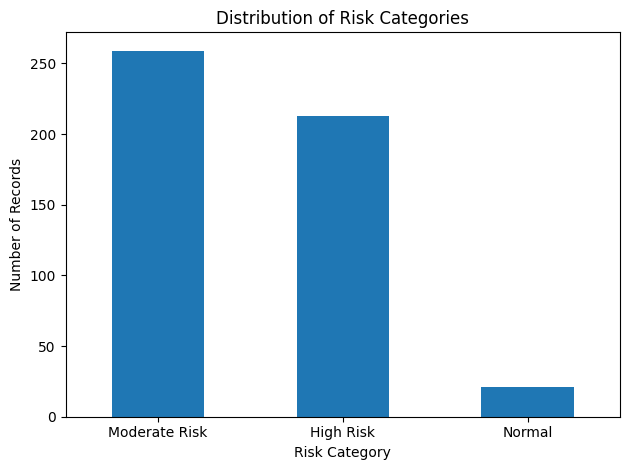

In [ ]:
import matplotlib.pyplot as plt

# Count the occurrences of each risk category
risk_counts = final_df["risk_category"].value_counts()

# Create a bar plot to show the distribution of risk categories
plt.figure()
risk_counts.plot(kind="bar")
plt.title("Distribution of Risk Categories") # Set the plot title
plt.xlabel("Risk Category") # Set the x-axis label
plt.ylabel("Number of Records") # Set the y-axis label
plt.xticks(rotation=0) # Ensure x-axis labels are not rotated
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


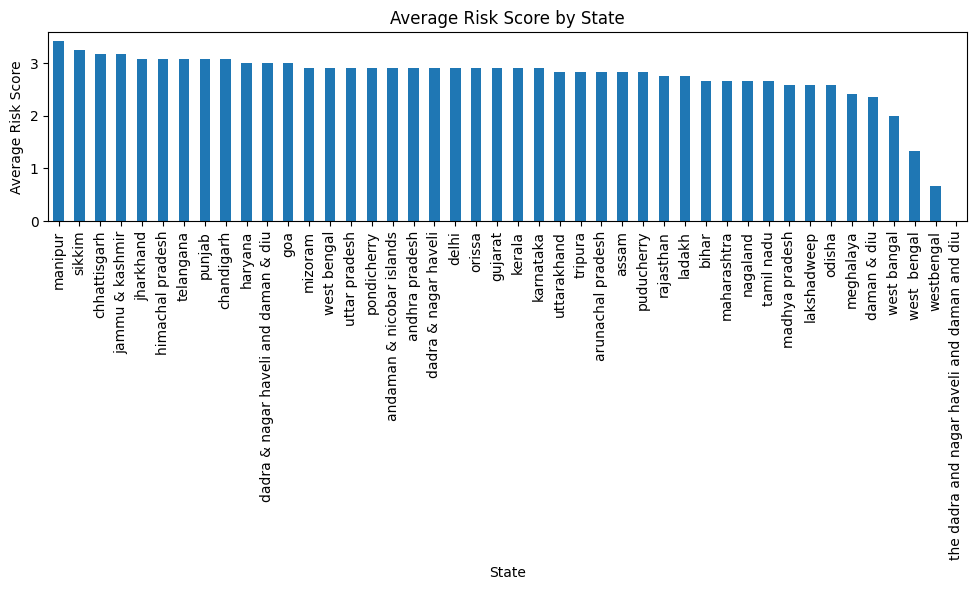

In [ ]:
import matplotlib.pyplot as plt

# Calculate the average risk score for each state and sort in descending order
state_risk = final_df.groupby("state")["risk_score"].mean().sort_values(ascending=False)

# Create a bar plot to visualize the average risk score by state
plt.figure(figsize=(10, 6))
state_risk.plot(kind="bar")
plt.title("Average Risk Score by State") # Set the plot title
plt.xlabel("State") # Set the x-axis label
plt.ylabel("Average Risk Score") # Set the y-axis label
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


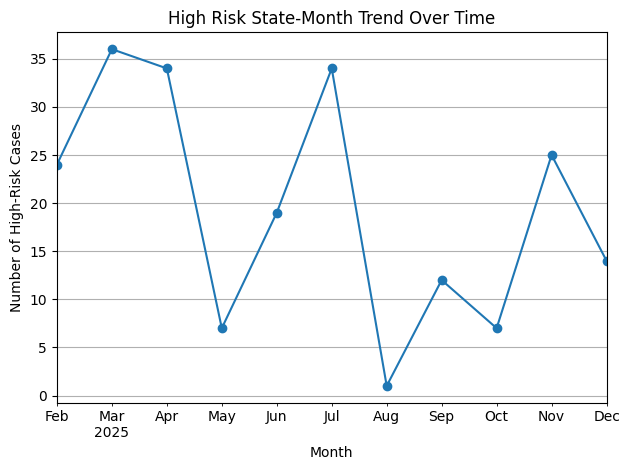

In [ ]:
import matplotlib.pyplot as plt

# Filter for 'High Risk' entries and count them per month
high_risk_trend = (
    final_df[final_df["risk_category"] == "High Risk"]
    .groupby("year_month")
    .size()
)

# Create a line plot to visualize the trend of high-risk cases over time
plt.figure()
high_risk_trend.plot(marker="o") # Plot with markers at each data point
plt.title("High Risk State-Month Trend Over Time") # Set the plot title
plt.xlabel("Month") # Set the x-axis label
plt.ylabel("Number of High-Risk Cases") # Set the y-axis label
plt.grid(True) # Add a grid for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()
